In [1]:
import json
import os
import sys

sys.path.append('../')
sys.path.append('../../')
sys.path.append('../src')
sys.path.append('../prompts')
sys.path.append('../src/llmperf')

# Run multiple models through the benchmarking process

In [7]:
results_dir = '../data/results/ankur_softbank_2'

# Analyze metrics through models

In [8]:
import pandas as pd
from typing import List
import plotly.graph_objects as go
import numpy as np

from benchmarking.utils import read_json_files

## Read the input json file

In [19]:
df = read_json_files(results_dir, type='summary')
df = df.set_index(['num_input_tokens','num_output_tokens','num_concurrent_requests'])
df.head(10)

,,,name,model,client_ttft_s_p25,client_ttft_s_p50,client_ttft_s_p75,client_ttft_s_p90,client_ttft_s_p95,client_ttft_s_p99,client_ttft_s_mean,client_ttft_s_min,...,acceptance_rate_stddev,num_requests_started,error_rate,number_errors,error_code_frequency,client_mean_output_token_per_s,num_completed_requests,num_completed_requests_per_min,model_idx,timestamp
num_input_tokens,num_output_tokens,num_concurrent_requests,,,,,,,,,,,,,,,,,,,,,
128,2048,2,9721c311-57fc-4eaf-9d13-fbb9aab72f56_synthetic...,Meta-Llama-3.1-70B-Instruct,2.5241,3.6385,4.7529,5.4215,5.6444,5.8227,3.6385,1.4097,...,0.0000,2,0.000000,0,{},397.3858,2,11.6422,0,1741374860
1800,2048,256,62175e84-524f-46ab-a621-bda2cc468890_synthetic...,Meta-Llama-3.1-70B-Instruct,28.5314,63.7517,98.8636,133.6760,133.7133,133.7835,71.3687,1.5618,...,0.0000,256,0.000000,0,{},3134.8911,256,105.0215,0,1741717107
128,2048,32,1c31c416-da2b-46b0-8712-cd4963619afc_synthetic...,Meta-Llama-3.1-70B-Instruct,6.3947,6.3983,6.4071,6.4096,6.4115,6.4127,6.2394,1.2584,...,0.2223,32,0.000000,0,{},2990.5425,32,87.6136,0,1741375167
2048,128,16,bbab9730-7a4e-40f5-8c25-02c59e76498f_synthetic...,Meta-Llama-3.1-70B-Instruct,7.0408,7.0437,7.0452,7.0474,7.0476,7.0478,6.7053,1.6323,...,0.3221,16,0.000000,0,{},268.4476,16,125.8348,0,1741373704
512,512,1,8ce93e91-b7f4-4149-8ae0-2b931930e16e_synthetic...,Meta-Llama-3.1-70B-Instruct,3.1381,3.1381,3.1381,3.1381,3.1381,3.1381,3.1381,3.1381,...,NaN,1,0.000000,0,{},119.6296,1,14.0191,0,1741371420
2048,128,512,4b462312-1911-45a4-b10b-9f9b7a43343a_synthetic...,Meta-Llama-3.1-70B-Instruct,44.3831,86.8104,128.9115,160.5925,160.6595,171.2164,90.1057,2.2189,...,0.0000,512,0.013672,7,{'Error while running LLM API requests. Check ...,374.6623,505,175.6230,0,1741374347
512,512,2,3f6e8231-2ba1-4242-b134-b570cd7ced6d_synthetic...,Meta-Llama-3.1-70B-Instruct,1.3651,1.3652,1.3652,1.3652,1.3652,1.3652,1.3652,1.3651,...,0.0000,2,0.000000,0,{},361.9962,2,42.4214,0,1741371484
128,2048,8,c8d1685d-6ea5-4a0e-a03b-afe0ae9488ba_synthetic...,Meta-Llama-3.1-70B-Instruct,1.3476,7.4590,7.4639,7.4644,7.4650,7.4655,5.1686,1.3432,...,0.0000,8,0.000000,0,{},1139.0898,8,33.3718,0,1741375007
1800,2048,1,7d0adb12-40ea-4b80-807b-0c3bed6be71f_synthetic...,Meta-Llama-3.1-70B-Instruct,2.6272,2.6272,2.6272,2.6272,2.6272,2.6272,2.6272,2.6272,...,NaN,1,0.000000,0,{},292.5046,1,9.7991,0,1741716532


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_benchmarking_data(df, ycol, ylabel):
    df = df.reset_index()
    # Create a new column combining 'in' and 'out' into a single legend label
    df['in_out'] = df.apply(lambda row: f"({row['num_input_tokens']}, {row['num_output_tokens']})", axis=1)

    plt.figure(figsize=(8, 5))
    
    # Plot main performance metric
    sns.lineplot(data=df, x='num_concurrent_requests', y=ycol, hue='in_out', marker='o', linewidth=2)
    
    # Plot client_output_token_per_sec as a dashed line
    if ycol=='output_token_per_s_p50' and 'client_output_token_per_s_p50' in df.columns:
        sns.lineplot(data=df, x='num_concurrent_requests', y='client_output_token_per_s_p50', hue='in_out', 
                     marker='o', linestyle='dashed', alpha=0.6)
    
    # Set x-axis to log2 scale
    plt.xscale("log", base=2)
    
    # Customize x-axis ticks to show real numbers instead of 2^n notation
    xticks = sorted(df['num_concurrent_requests'].unique())
    plt.xticks(xticks, labels=[str(x) for x in xticks])
    
    # Labels and title
    plt.xlabel("Concurrency [log2 scale]")
    plt.ylabel(ylabel)
    if ycol=='output_token_per_s_p50':
        plt.title("Performance for Different (in, out) Token Combinations\n(Solid = Server, Dashed = Client)")
    else:
        plt.title("Performance for Different (in, out) Token Combinations")
    
    plt.legend(title="(in, out)", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, which="both", linestyle="--")
    
    plt.show();

/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


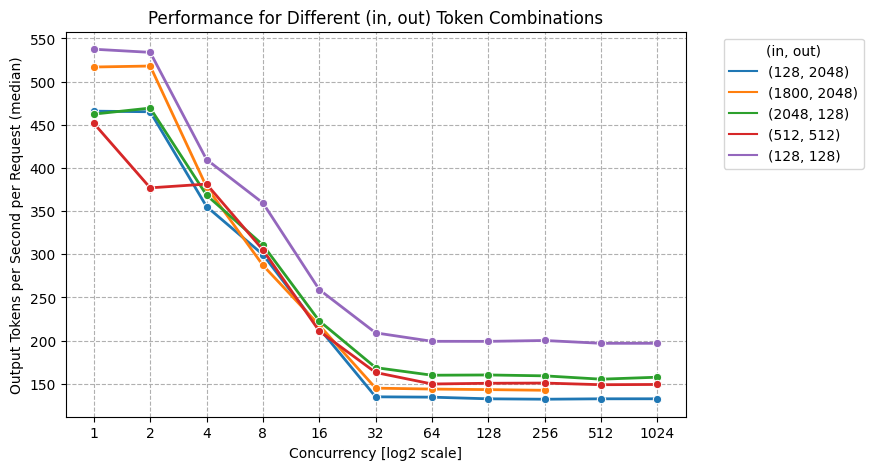

/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


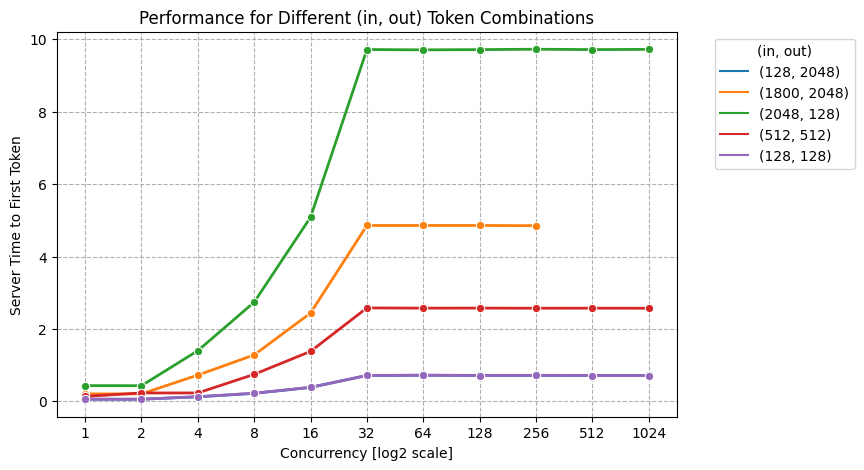

/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


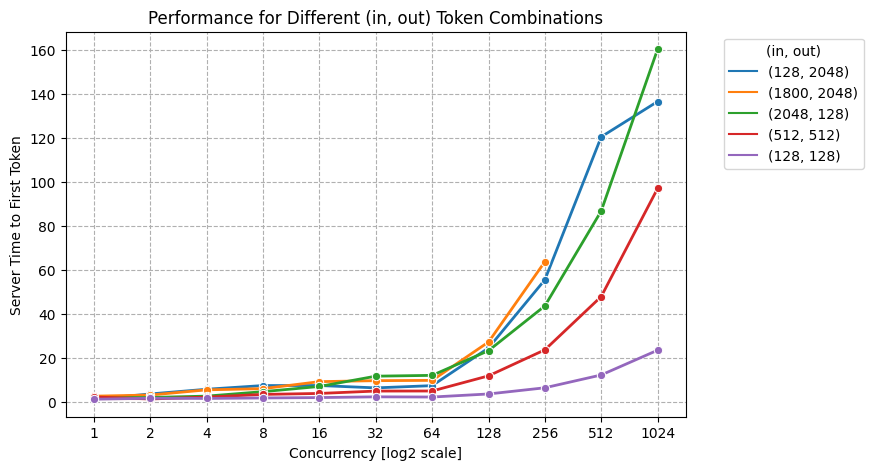

/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


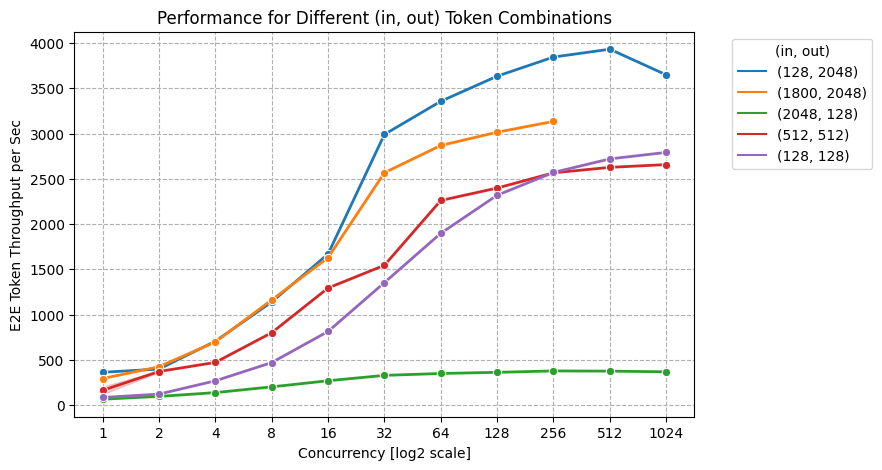

In [18]:
plot_benchmarking_data(df, 'server_output_token_per_s_p50', 'Output Tokens per Second per Request (median)')
plot_benchmarking_data(df, 'server_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_mean_output_token_per_s', 'E2E Token Throughput per Sec')


# Analyze switching time

__Note:__ This analysis will work if a Bundle endpoint is used. Users will be able to test and compare performance metrics for different experts.

In [ ]:
# post processing individual request json files
def read_json_files_to_df(directory: str) -> pd.DataFrame:
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('individual_responses.json'):
            model_name = '_'.join(filename.split('_')[:2])
            file_path = os.path.join(directory, filename)
            # Read the JSON file
            with open(file_path, 'r') as file:
                json_data = json.load(file)

                # Extract relevant fields from each JSON object and append to the data list
                for item in json_data:
                    if pd.isnull(item['error_code']):
                        data.append(
                            {
                                'start_time': item['start_time'],
                                'end_time': item['end_time'],
                                'server_ttft_s': item['server_ttft_s'],
                                'model_name': model_name,
                            }
                        )

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)
    return df

# Get the DataFrame
df = read_json_files_to_df(results_dir)

# transforming str to date time for sorting
df['start_time'] = pd.to_datetime(df['start_time'])
df = df.sort_values(by=['start_time'])

# transforming back to str for plotting
df['start_time'] = df['start_time'].dt.strftime(date_format='%H:%M:%S')
df

In [ ]:
# Initialize a column for the switching time
df['server_switching_time'] = None

# Group by model_name
grouped = df.groupby('model_name')

# Iterate through each group to calculate switching time
for name, group in grouped:
    if len(group) > 1:
        first_ttft = group['server_ttft_s'].iloc[0]
        mean_ttft = group['server_ttft_s'].iloc[1:].mean()
        std_ttft = group['server_ttft_s'].iloc[1:].std()
        std_ttft = 1e-16 if np.isnan(std_ttft) else std_ttft
        switching_time = first_ttft - mean_ttft
        if switching_time > (mean_ttft + 3 * std_ttft):
            df.loc[group.index[0], 'server_switching_time'] = switching_time
        else:
            None
    else:
        df.loc[group.index[0], 'server_switching_time'] = None

with pd.option_context(
    'display.max_rows',
    None,
):
    display(df)

In [ ]:
# Create a scatter plot
plt.figure(figsize=(40, 12))
sns.scatterplot(x='start_time', y='server_ttft_s', hue='model_name', data=df, s=100, alpha=0.7)

# Identify and plot the first datapoint for each model_name with a red color and bold marker
first_points = df.groupby('model_name').first().reset_index()
plt.scatter(
    first_points['start_time'],
    first_points['server_ttft_s'],
    color='red',
    s=150,
    edgecolor='black',
    linewidth=2,
    label='First TTFT',
)

# Customize the plot
plt.title('Scatter Plot of server_ttft_s Over Time by Model Name')
plt.xlabel('Start Time')
plt.ylabel('Server TTFT (s)')
plt.legend(title='Model Name', loc='upper left')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()